In [2]:
#Read the data and labels
def readData(file):
    from six.moves import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo,encoding='latin1')
        data = dict['data']
        labels = dict['labels']
    return(data,labels)

In [1]:
#Split data into train and test
def trainTest():
    x,y = readData("/home/kritz/Downloads/cifar-10-python/cifar-10-batches-py/data_batch_1")
    
    '''Using only one batch due to less computation power available'''
    #for i in range(2,6):
        #xTemp,yTemp = readData("/home/kritz/Downloads/cifar-10-python/cifar-10-batches-py/data_batch_"+str(i))
        #x = np.append(x, xTemp, axis=0)
        #y = np.append(y, yTemp, axis=0)

    y = np.array(y)
    y = np.reshape(y,((len(y),1)))

    #Test data
    testX,testY = readData("/home/kritz/Downloads/cifar-10-python/cifar-10-batches-py/test_batch")
    testY = np.array(testY)
    testY = np.reshape(testY,((len(testY),1)))

    cat = 32
    imgSize = 32
    imgChannels = 3

    #Seperating data into pixels and color channel
    x = x.reshape([-1, imgChannels, imgSize, cat])
    testX = testX.reshape([-1, imgChannels, imgSize, cat])
    
    #ONe hot encoding for output variables
    encodedTrain = np.zeros((len(y), 10))
    for idx, val in enumerate(y):
        encodedTrain[idx][val] = 1
        
    encodedTest = np.zeros((len(testY), 10))
    for idx, val in enumerate(testY):
        encodedTest[idx][val] = 1
    
    return (testX,encodedTest,x,encodedTrain)

In [44]:
def tfResize(each):
    IMAGE_SIZE = 225
    X_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, (None, None, 3))
    tf_img = tf.image.resize_images(X, (IMAGE_SIZE, IMAGE_SIZE), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Each image is resized individually as different image may be of different size.
        #for each in trainX:
        resized_img = sess.run(tf_img, feed_dict = {X: each})
        #X_data.append(resized_img)

    X_data = np.array(resized_img, dtype = np.float32) # Convert to numpy
    return X_data

In [33]:
def tfRotate(img):
    X_rotate = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (3,32,32))
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k = k)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #for img in X_imgs:
        for i in range(3):  # Rotation at 90, 180 and 270 degrees
            rotated_img = sess.run(tf_img, feed_dict = {X: img, k: i + 1})
            #X_rotate.append(rotated_img)
        
    X_rotate = np.array(rotated_img, dtype = np.float32)
    return X_rotate

(3, 32, 32)


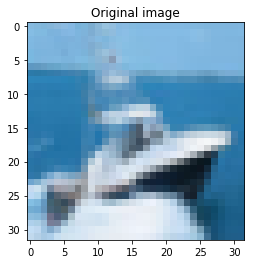

(225, 225, 3)


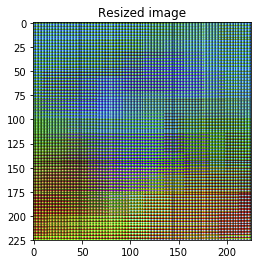

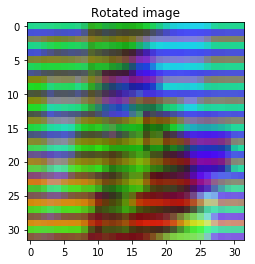

In [53]:
#Importing packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#Reading the test and train data
testX,testY,trainX,trainY = trainTest()

print(trainX[8].shape)
#Looking at a sample image
rgb = trainX[8]
img = rgb.reshape(3,32,32).transpose([1, 2, 0])
plt.title("Original image")
plt.imshow(img)
plt.show()

#Data Augmentation: 1.resizing data
resized = tfResize(trainX[8,].transpose([1,2,0]))
rgb = resized
print(rgb.shape)
img = rgb.reshape(3,225,225).transpose([1, 2, 0])
plt.title("Resized image")
plt.imshow(img)
plt.show()

#2.Rotating the images
rotated = tfRotate(trainX[8,])
rgb = rotated
img = rgb.reshape(3,32,32).transpose([1, 2, 0])
plt.title("Rotated image")
plt.imshow(img)
plt.show()


trainX = trainX.transpose([0, 2, 3, 1])
testX = testX.transpose([0, 2, 3, 1])

In [102]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

logs_path = "/tmp/cnn/5"

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

#Defining convolution network
def convNet(x, keep_prob):
    convFilter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    
    #Convolution layer with ReLU
    conv = tf.nn.conv2d(x, convFilter, strides=[1,1,1,1], padding='SAME')
    conv = tf.nn.relu(conv)
    #tf.summary.histogram("convolution layer", conv)
    
    #Max pool layer
    convPool = tf.nn.max_pool(conv, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    #tf.summary.histogram("Max pool layer", convPool)
    
    #Flatten to feed as input to fully connnected layer with ReLU
    flat = tf.contrib.layers.flatten(convPool)  
    full = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full = tf.nn.dropout(full, keep_prob)
    full = tf.layers.batch_normalization(full)
    #tf.summary.histogram("Fully connected layer", full)
    
    #Output layer with softmax activation
    out = tf.contrib.layers.fully_connected(inputs=full, num_outputs=10, activation_fn=None)
    out = tf.nn.softmax(out)
    #tf.summary.histogram("Output activation", out)
    return out


def trainNn(session, optimizer, keep_probability, feature, label):
    session.run(optimizer, feed_dict={x: feature, y: label, keep_prob: keep_probability})

    
epochs = 10
batchSize = 1024
keep_probability = 0.5
learning_rate = 0.001

logits = convNet(x, keep_prob)
model = tf.identity(logits, name='logits') # Name logits Tensor

# Loss and Optimizer
with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
tf.summary.histogram("cost", cost)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
tf.summary.histogram("accuracy", accuracy)

accuracy_summary = tf.summary.scalar("Test Accuracy", accuracy)

summary_op = tf.summary.merge_all()
with tf.Session() as sess:
    
    aug = trainX
    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # log writer object
    writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    test_writer = tf.summary.FileWriter(logs_path + '/test', graph=tf.get_default_graph())
    
    batches = int(np.ceil(len(aug) / batchSize))
    for each in range(epochs):
        for i in range(batches):
            batchX = aug[i*batchSize: (i+1)*batchSize]
            batchY = trainY[i*batchSize: (i+1)*batchSize]
            
            trainNn(sess, optimizer, keep_probability, batchX, batchY)
            summary,_,c,accu = sess.run([summary_op,optimizer,cost,accuracy], feed_dict={x: batchX,y: batchY,keep_prob: 1.0})
            summ,_,acc = sess.run([accuracy_summary,optimizer,accuracy],feed_dict={x: testX[:100,],y: testY[:100,],keep_prob: 1.0})
            test_writer.add_summary(summary, i)
            writer.add_summary(summ,i)
            writer.flush()
            
        print("Epoch : ",each+1)


INFO:tensorflow:Summary name Test Accuracy is illegal; using Test_Accuracy instead.
Epoch :  1
Epoch :  2
Epoch :  3
Epoch :  4
Epoch :  5
Epoch :  6
Epoch :  7
Epoch :  8
Epoch :  9
Epoch :  10


In [106]:
!tensorboard --logdir="/tmp/cnn2/3"

2018-06-09 00:17:43.071034: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
TensorBoard 1.8.0 at http://krithika:6006 (Press CTRL+C to quit)
^C


In [105]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

logs_path = "/tmp/cnn2/3"

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

def conv_net(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))
    
    #concolution layer with SeLU
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.selu(conv1)
    
    #Max Pooling
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    #Normalization
    conv1_bn = tf.layers.batch_normalization(conv1_pool)
    
    #Max pooling
    conv1_pool2 = tf.nn.max_pool(conv1_bn, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    #Flatten
    flat = tf.contrib.layers.flatten(conv1_pool2)  

    #Fully connected layer 1 with seLU
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.selu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    #Fully connected layer 2 with seLU
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.selu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    #Output layer with softmax
    out = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=10, activation_fn=None)
    out = tf.nn.softmax(out)
    return out


def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probability})

    
epochs = 10
batchSize = 1024
keep_probability = 0.5
learning_rate = 0.001

logits = conv_net(x, keep_prob)
model = tf.identity(logits, name='logits') # Name logits Tensor, so that can be loaded from disk after training

# Loss and Optimizer
with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tf.summary.histogram("accuracy", accuracy)
accuracy_summary = tf.summary.scalar("Test Accuracy", accuracy)
summary_op = tf.summary.merge_all()

with tf.Session() as sess:
    aug1 = trainX 
    #aug.eval(session = sess)
    # Initializing the variables
    #aug1 = aug.eval(session=sess)
    sess.run(tf.global_variables_initializer())
    
    # log writer object
    writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    test_writer = tf.summary.FileWriter(logs_path + '/test', graph=tf.get_default_graph())
    
    batches = int(np.ceil(len(aug1) / batchSize))
    for each in range(epochs):
        for i in range(batches):
            batchX = aug1[i*batchSize: (i+1)*batchSize]
            batchY = trainY[i*batchSize: (i+1)*batchSize]
            train_neural_network(sess, optimizer, keep_probability, batchX, batchY)
            summary,_,c,accu =  sess.run([summary_op,optimizer,cost,accuracy], feed_dict={x: batchX,y: batchY,keep_prob: 1.0})
            summ,_,acc = sess.run([accuracy_summary,optimizer,accuracy],feed_dict={x: testX[:100,],y: testY[:100,],keep_prob: 1.0})
            test_writer.add_summary(summary, i)
            writer.add_summary(summ,i)
            writer.flush()
        print("Epoch ", each+1)
            

INFO:tensorflow:Summary name Test Accuracy is illegal; using Test_Accuracy instead.
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
